# Preprocessing


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Functions_examples import *

## Load data 

In [3]:
data = load_pickle_variable('../Data/Dataset_4subjects_Exe_Obs')

## Subsample the data 

Sampling frequency :

Subsampling : 500 Hz (suggested)

_make sure to respect the Nyquist theorem_

In [4]:
datac = data.copy()
subsample_rate = 2048 // 500

for subject, sub_data in datac.items():
    for session, sess_data in sub_data.items():
        nb_channels = len(sess_data['channel_labels'])
        sess_data['sub_neural_data'] = {}
        for channel in range(nb_channels):
            sess_data['sub_neural_data'][channel] = sess_data['neural_data'][channel][::subsample_rate]

## Problems due to bipolar referencing

For every electrode shaft, if a signal looks weird (=flat), it is likely that the signal is bipolar-referenced. The signal needs to be removed

## Filtering 

sEEG data : up to 150 Hz

Divide the signals in the usual different frequency bands :
- Delta (0.5-4 Hz)
- Theta (4-8 Hz)
- Alpha (8-13 Hz)
- Beta (13-30 Hz)
- Gamma (30-100 Hz)

Maybe try other separations of frequency bands (e.g. low and high gamma, low and high beta, etc.)

In [12]:
from scipy.signal import butter, sosfilt

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply a bandpass filter to the input data.

    Parameters:
    - data: 1D NumPy array, the signal to filter.
    - lowcut: float, lower frequency of the band (Hz).
    - highcut: float, upper frequency of the band (Hz).
    - fs: float, sampling frequency of the signal (Hz).
    - order: int, the order of the filter.

    Returns:
    - filtered_data: 1D NumPy array, the filtered signal.
    """
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return sosfilt(sos, data)

freq_bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 100)
}

sub_data = datac['s6']['sess1']['sub_neural_data']
filtered_data = {}
for band_name, (low, high) in freq_bands.items():
    filtered_data[band_name] = []
    for channel in range(len(sub_data)):
        filtered_channel = bandpass_filter(sub_data[channel], low, high, 500)
        filtered_data[band_name].append(filtered_channel)
    print(band_name)

Delta
Theta
Alpha
Beta
Gamma


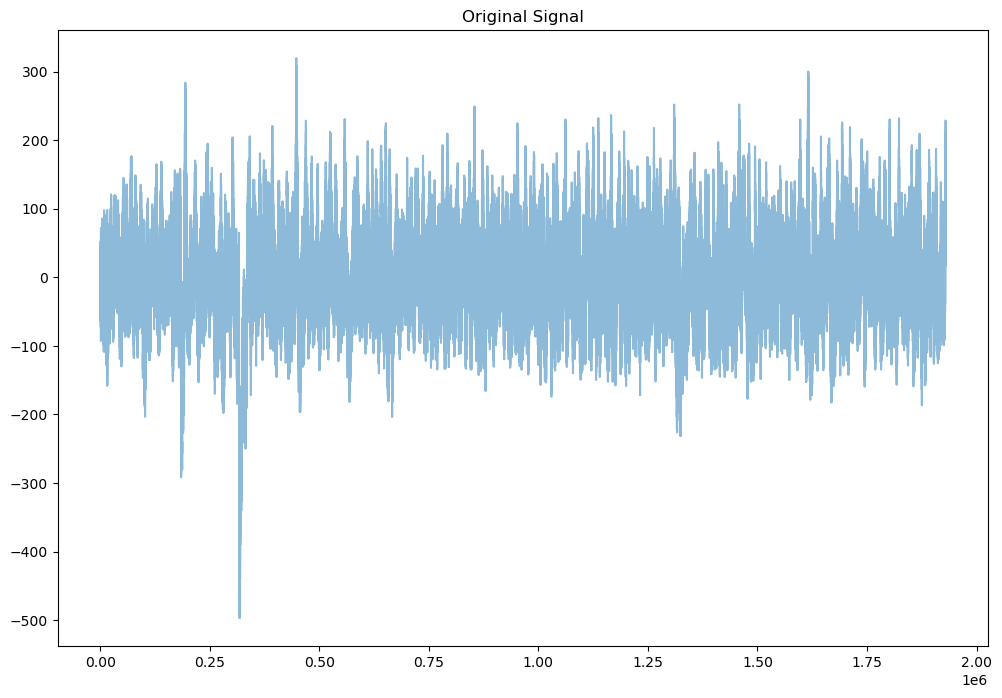

c:\Users\Admin\Anaconda3\envs\tne\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


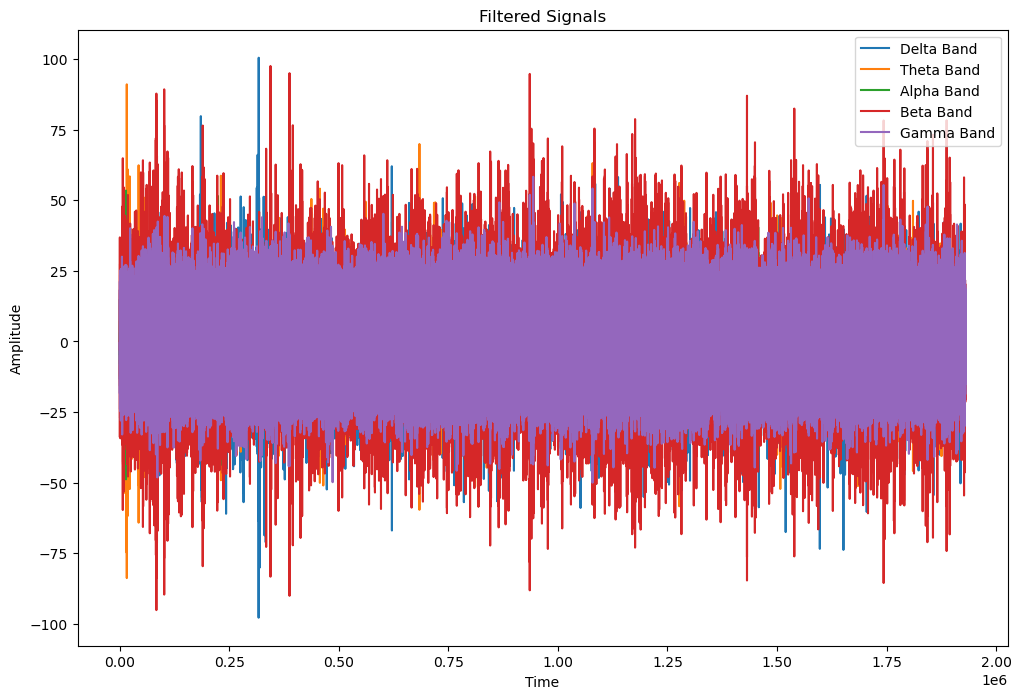

In [20]:
channel_idx = 0

time = np.arange(len(sub_data[channel_idx]))
plt.figure(figsize=(12, 8))
plt.plot(time, sub_data[channel_idx], label="Original Signal", alpha=0.5)
plt.title("Original Signal")
plt.show()

plt.figure(figsize=(12, 8))

for band_name, signals in filtered_data.items():
    plt.plot(time, signals[channel_idx], label=f"{band_name} Band")

plt.title("Filtered Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

## Normalization

Methods 
- Normalize the data related to the trial itself by its respective baseline 
    -  1 second before TrialStart and CueOne
- Normalize the data related to the average baseline
    - Average of the segment from TrialStart to CueOne from all trials 

## Trial duration

Every trial have a different duration 

Methods 
- Cut segments of neural data around a certain trigger of interes 
- Normalizing the duration of the trials loosing the absolute temporal information
    - Every trial corresponds to 100% of the movement
    - Subsample or upsample every trial to have the same number of points 